In [1]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
from shutil import copyfile

%matplotlib inline

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [3]:
is_cuda = torch.cuda.is_available()
is_cuda

True

In [4]:
path = "./dogsandcats/"
if os.path.isdir(path)==False:
    os.mkdir(path)
    for t in ['train','valid']:
        os.mkdir(os.path.join(path,t))
        for folder in ['dog/','cat/']:
            os.mkdir(os.path.join(path,t,folder)) 
            
def prepare_data(files):
    shuffle = np.random.permutation(len(files))
    train_num=200
    valid_num=50
    file_num = 0
    
    if "train" in files[0]:
        file_num = train_num
    else:
        file_num= valid_num
    
    for i in shuffle[:file_num]:
        info = files[i].split('/')
        phase, gen, name = info[-3], info[-2], info[-1]
        copyfile(files[i],os.path.join(path,phase,gen,name))
     

In [5]:
files_train_dog = glob(os.path.join("../Chapter03/dogsandcats/train/dog/",'*.jpg'))
files_train_cat = glob(os.path.join("../Chapter03/dogsandcats/train/cat/",'*.jpg'))
files_valid_dog = glob(os.path.join("../Chapter03/dogsandcats/valid/dog/",'*.jpg'))
files_valid_cat = glob(os.path.join("../Chapter03/dogsandcats/valid/cat/",'*.jpg'))

prepare_data(files_train_dog)
prepare_data(files_train_cat)
prepare_data(files_valid_dog)
prepare_data(files_valid_cat)



## Utility functions

In [11]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
    
class LayerActivations():
    features=[]
    
    def __init__(self,model):
        self.features = []
        self.hook = model.register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        
        self.features.extend(output.view(output.size(0),-1).cpu().data)

    
    def remove(self):
        
        self.hook.remove()
    
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)
    
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

## Creating PyTorch datasets

In [12]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [13]:
# For Dogs & Cats dataset
train_dset = ImageFolder('./dogsandcats/train/',transform=data_transform)
val_dset = ImageFolder('./dogsandcats/valid/',transform=data_transform)
classes=2

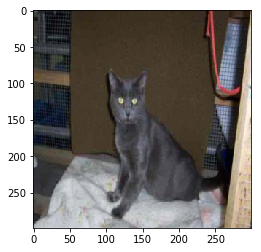

In [14]:
imshow(train_dset[150][0])

In [15]:
len(train_dset)

794

## Creating data loader for training and validation datasets

In [16]:
train_loader = DataLoader(train_dset,batch_size=32,shuffle=False,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=32,shuffle=False,num_workers=3)

## Creating Inception V3 model

In [17]:
my_inception = inception_v3(pretrained=True)
my_inception.aux_logits = False
if is_cuda:
    my_inception = my_inception.cuda()

## Extracting Convolutional features

In [18]:
# Create LayerActivations object to store the output of inception model at a particular layer.
trn_features = LayerActivations(my_inception.Mixed_7c)




In [19]:
# Passing all the data through the model , as a side effect the outputs will get stored 
# in the features list of the LayerActivations object. 
trn_labels = []
for da,la in train_loader:
    _ = my_inception(da.cuda())
    trn_labels.extend(la)
trn_features.remove()



RuntimeError: CUDA error: out of memory

In [ ]:
# Repeat the same process for validation dataset .

val_features = LayerActivations(my_inception.Mixed_7c)
val_labels = []
for da,la in val_loader:
    _ = my_inception(Variable(da.cuda()))
    val_labels.extend(la)
val_features.remove()

In [ ]:
len(val_labels)

In [ ]:
trn_features.features[0].size()

In [ ]:
len(trn_features.features)

## Creating train and validation feature dataset

In [ ]:
#Dataset for pre computed features for train and validation data sets

trn_feat_dset = FeaturesDataset(trn_features.features,trn_labels)
val_feat_dset = FeaturesDataset(val_features.features,val_labels)

#Data loaders for pre computed features for train and validation data sets

trn_feat_loader = DataLoader(trn_feat_dset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=64)

## A Fully connected network

In [ ]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self,in_size,out_size,training=True):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = F.dropout(inp, training=self.training)
        out = self.fc(out)
        return out

# The size of the output from the selected convolution feature 
fc_in_size = 131072

fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.cuda()

In [ ]:
optimizer = optim.Adam(fc.parameters(),lr=0.01)

## Train and validate the model

In [ ]:

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc.eval(),val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

In [ ]:
optimizer.param_groups[0]['lr']= 0.0001

In [ ]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

In [ ]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

#Results

training loss is  0.78 and training accuracy is 22825/23000     99.24
validation loss is   5.3 and validation accuracy is 1947/2000     97.35
training loss is  0.84 and training accuracy is 22829/23000     99.26
validation loss is   5.1 and validation accuracy is 1952/2000      97.6
training loss is  0.69 and training accuracy is 22843/23000     99.32
validation loss is   5.1 and validation accuracy is 1951/2000     97.55
training loss is  0.58 and training accuracy is 22852/23000     99.36
validation loss is   4.9 and validation accuracy is 1953/2000     97.65
training loss is  0.67 and training accuracy is 22862/23000      99.4
validation loss is   4.9 and validation accuracy is 1955/2000     97.75
training loss is  0.54 and training accuracy is 22870/23000     99.43
validation loss is   4.8 and validation accuracy is 1953/2000     97.65
training loss is  0.56 and training accuracy is 22856/23000     99.37
validation loss is   4.8 and validation accuracy is 1955/2000     97.75
training loss is   0.7 and training accuracy is 22841/23000     99.31
validation loss is   4.8 and validation accuracy is 1956/2000      97.8
training loss is  0.47 and training accuracy is 22880/23000     99.48
validation loss is   4.7 and validation accuracy is 1956/2000      97.8